# Here, we decide to learn tensorflow from a simple example directly!

## General writing flow
1. import required libraries
2. load data and do some data pre-processing
3. split your data into training and validation set
4. build the network
5. train the model and record/monitoring the performance

## 1. Import required libries and set some parameters 

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import os

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''設定參數'''
batch_size =32
epochs = 100
lr = 0.001
train_ratio= 0.9

'''或者你可以將以上參數換成下面的呈現方式'''
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument('--batch_size', default = 32, type = int)
# parser.add_argument('--epochs', default = 100, type = int)
# parser.add_argument('--lr', default = 0.001, type = float)
# parser.add_argument('--train_ratio', default = 0.9, type = float)
# FLAGS = parser.parse_args([]) # if not jupyter notebook, remove []

'或者你可以將以上參數換成下面的呈現方式'

In [3]:
# You should always set visible devices before importing tensorflow
#os.environ['CUDA_VISIBLE_DEVICES'] = str(FLAGS.gpu_id)
import tensorflow as tf

## 2. Load data and do some pre-processing
We use MNIST HERE (with sklearn 8x8 version rather than use tensorflow 28x28 version)

In [4]:
from sklearn.datasets import load_digits
# -----------------------------load data----------------------------------------
digits = load_digits()
x_, y_ = digits.data, digits.target

# -----------------------do data pre-processing--------------------------------- 
#---------one way of normalization--------
x_ = x_ / x_.max() 


#---------將資料做One-Hot Encoding---------
y_one_hot = np.zeros((len(y_), 10))  
y_one_hot[np.arange(len(y_)), y_] = 1

# 

## 3. Split your data into training and validation sets

In [5]:
#----------------------------資料training set, testing set 分割---------------------------------------
x_train, x_test, y_train, y_test = train_test_split(x_, 
                                                    y_one_hot, 
                                                    test_size = 0.05, 
                                                    stratify  = y_)
#資料training set, validation set 分割
x_train, x_valid, y_train, y_valid = train_test_split(x_train, 
                                                      y_train, 
                                                      test_size = 1.0 - train_ratio,
                                                      stratify = y_train.argmax(axis = 1))
#------------------------------------檢查資料---------------------------------------------------------
print("training set data dimension")
print(x_train.shape)
print(y_train.shape)
print("-----------")
print("training set: %i" % len(x_train))
print("validation set: %i" % len(x_valid))
print("testing set: %i" % len(x_test))

training set data dimension
(1536, 64)
(1536, 10)
-----------
training set: 1536
validation set: 171
testing set: 90


# 以下有兩種方法去搭建network

## $\star$ (法一) $\star$ 
## 4a.Build the network with low-level tensor elements

In [10]:
# ------------------------------------------graph------------------------------------------------
tf.reset_default_graph() # clean graph

#------------Declare the input node (Input layer)---------------
with tf.name_scope('input'):
    x_input = tf.placeholder(shape = (None,x_train.shape[1]), 
                             name = 'x_input',
                             dtype=tf.float32)
    y_out = tf.placeholder(shape = (None, y_train.shape[1]), 
                           name = 'y_label',
                           dtype=tf.float32)
#-----------------------hidden layer----------------------------    
with tf.variable_scope('hidden_layer'):
    w1 = tf.get_variable('weight1', 
                         shape= [x_train.shape[1], 25], 
                         dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer(stddev=0.1))
    b1 = tf.get_variable('bias1', 
                         shape= [25], 
                         dtype=tf.float32, 
                         initializer=tf.constant_initializer(0.0))  
    x_h1 = tf.nn.relu(tf.add(tf.matmul(x_input, w1), b1))
#-----------------------output layer----------------------------    
with tf.variable_scope('output_layer'):
    w2 = tf.get_variable('weight2',
                         shape=[25, y_train.shape[1]],
                         dtype=tf.float32,
                         initializer=tf.truncated_normal_initializer(stddev=0.1))
    b2 = tf.get_variable('bias2', 
                         shape=[y_train.shape[1]], 
                         dtype=tf.float32, 
                         initializer=tf.constant_initializer(0.0))
    output = tf.add(tf.matmul(x_h1, w2), b2)

#-----------------------lost function(cross entropy)-------------
with tf.name_scope('cross_entropy'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_out))
#-----------------------accuracy---------------------------------    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(output),1), tf.argmax(y_out,1)) #如果答案對則回傳truth
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #將回傳的truth/false轉乘1/0並計算平均(計算正確率)
#-----------------------optimizer---------------------------------
with tf.name_scope('train'):
    #使用adam做optimization最小化loss funciotn(不斷取微分並逼近local min)
    train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

## 5a. Train the model and collect the performance

100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


--- training done ---
testing accuracy: 0.94


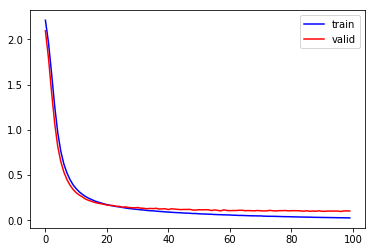

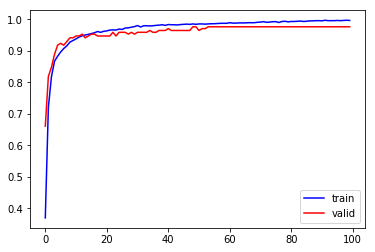

In [11]:
train_loss_list, valid_loss_list = [], []
train_acc_list, valid_acc_list = [], []
#-------------------------------------------------------sess-------------------------------------------------------
with tf.Session() as sess:
    # we have to initalize all variables (e.g. weights/biases) at beginning.
    sess.run([tf.global_variables_initializer()])
    # writer = tf.summary.FileWriter("./graph/", sess.graph)
    for i in tqdm(range(epochs)):
        # get batch 
        total_batch = int(np.floor(len(x_train) / batch_size)) 
        # 透過batch size 與資料量計算有幾個batch， just drop out last few samples ...
        
        train_loss_collector, train_acc_collector = [], []
        for j in np.arange(total_batch):
            #-------------------------------取一個batch 的資料-------------------------------------
            batch_idx_start = j * batch_size
            batch_idx_stop = (j+1) * batch_size

            x_batch = x_train[batch_idx_start : batch_idx_stop] 
            y_batch = y_train[batch_idx_start : batch_idx_stop]
            #------------------------------------------------------------------------------------
            this_loss, this_acc, _ = sess.run([loss, compute_acc, train_step], 
                                    feed_dict = {x_input: x_batch,
                                                 y_out: y_batch})
            # run上一個cell最後三個tensor得到loss值,正確率,和一次優化(得到新的weight 和biases)
            train_loss_collector.append(this_loss) #記錄每個batch的loss
            train_acc_collector.append(this_acc)   #記錄每個batch的acc
            
        # do validation at the end of each epoch(run完一個epoch後，計算一下validation acc 與 validation loss)
        valid_acc, valid_loss = sess.run([compute_acc, loss],
                                         feed_dict = {x_input: x_valid,
                                                      y_out : y_valid})
        valid_loss_list.append(valid_loss) #記錄validation loss
        valid_acc_list.append(valid_acc)   #記錄validation acc
        train_loss_list.append(np.mean(train_loss_collector)) #記錄每個epoch 平均 loss
        train_acc_list.append(np.mean(train_acc_collector))   #記錄每個epoch 平均 acc

        # at the end of each epoch, shuffle the data 重新排列資料並進入下一個i(epochs)
        x_train, y_train = shuffle(x_train, y_train)
    # At the end of the training, do testing set
    test_acc, test_loss = sess.run([compute_acc, loss],
                                    feed_dict = {x_input: x_test,
                                                 y_out : y_test})
print('--- training done ---')
print('testing accuracy: %.2f' % test_acc)
#------------------------------------------------------plot----------------------------------------------------------
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_loss_list)), valid_loss_list, 'r', label = 'valid')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_acc_list)), valid_acc_list, 'r', label = 'valid')
plt.legend(loc = 4)
plt.title("Accuracy")
plt.show()

## $\star$ (法二) $\star$
## 4b. Build the network with "layer" 

In [12]:
# ------------------------------------graph-----------------------------------------
tf.reset_default_graph() # clean graph
# Declare the input node
with tf.name_scope('input'):
    x_input = tf.placeholder(shape = (None,x_train.shape[1]), 
                             name = 'x_input',
                             dtype=tf.float32)
    y_out = tf.placeholder(shape = (None, y_train.shape[1]), 
                           name = 'y_label',
                           dtype=tf.float32)

# --------------------Declare the network structure----------------------------
"""---------與上面不一樣的地方(將一個layer的所有程式用一個內建function取代)----------"""
with tf.variable_scope('hidden_layer'):
    x_h1 = tf.layers.dense(inputs= x_input, units= 25, activation=tf.nn.relu)


with tf.variable_scope('output_layer'):
    output = tf.layers.dense(x_h1, 10)
'''---------------------------------------------------------------------------'''
with tf.name_scope('cross_entropy'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_out))
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(output),1), tf.argmax(y_out,1))
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

## 5b. Train the model and collect the performance

100%|██████████| 100/100 [00:10<00:00,  9.20it/s]


--- training done ---
testing accuracy: 0.98


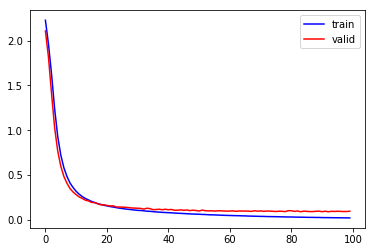

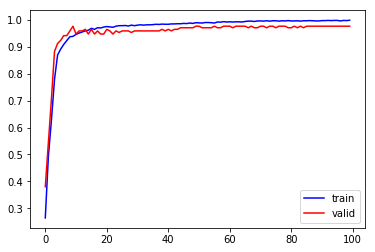

In [13]:
train_loss_list, valid_loss_list = [], []
train_acc_list, valid_acc_list = [], []
#--------------------------------------sess--------------------------------------------
with tf.Session() as sess:
    # we have to initalize all variables (e.g. weights/biases) at the begin
    sess.run([tf.global_variables_initializer()])
    
    for i in tqdm(range(epochs)):
        # get batch 
        total_batch = int(np.floor(len(x_train) / batch_size)) # just drop out last few samples...
        
        train_loss_collector, train_acc_collector = [], []
        for j in np.arange(total_batch):
            batch_idx_start = j * batch_size
            batch_idx_stop = (j+1) * batch_size

            x_batch = x_train[batch_idx_start : batch_idx_stop]
            y_batch = y_train[batch_idx_start : batch_idx_stop]
            
            this_loss, this_acc, _ = sess.run([loss, compute_acc,train_step],
                                    feed_dict = {x_input: x_batch,
                                                 y_out: y_batch})
            train_loss_collector.append(this_loss)
            train_acc_collector.append(this_acc)
            
        # do validation at the end of each epoch
        valid_acc, valid_loss = sess.run([compute_acc, loss],
                                         feed_dict = {x_input: x_valid,
                                                      y_out : y_valid})
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
        train_loss_list.append(np.mean(train_loss_collector))
        train_acc_list.append(np.mean(train_acc_collector))

        # at the end of each epoch, shuffle the data
        x_train, y_train = shuffle(x_train, y_train)
    # At the end of the training, do testing set
    test_acc, test_loss = sess.run([compute_acc, loss],
                                    feed_dict = {x_input: x_test,
                                                 y_out : y_test})
print('--- training done ---')
print('testing accuracy: %.2f' % test_acc)
#--------------------------------------plot---------------------------------------------
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_loss_list)), valid_loss_list, 'r', label = 'valid')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_acc_list)), valid_acc_list, 'r', label = 'valid')
plt.legend(loc = 4)
plt.title("Accuracy")
plt.show()

## Exercise1: 
用自訂義的 variables and bias 做成 3 個 hidden layer (25, 25, 25) 的 Neural netowrk

## Exercise2: 
用 tf.layers 做成 3 個 hidden layer (25, 25, 25) 的 Neural netowrk
